**Imports and functions**

In [2]:
import sympy as sym

import numpy as np

import evol_dynamics

from sympy import mathematica_code

In [3]:
def invariant_distribution_analytically(M):
    size = M.shape[1]
    pi = sym.symbols(f"b_1:{size + 1}")
    ss = sym.solve(
        [sum(pi) - 1]
        + [a - b for a, b in zip(M.transpose() * sym.Matrix(pi), pi)],
        pi,
    )

    v_vector = sym.Matrix(
        [
            [ss[p] for p in pi],
        ]
    )

    return v_vector

In [4]:
def ss_last_round(player, opponent, delta):
    """
    """
    v_zero = np.array(evol_dynamics.expected_distribution_opening_round(player, opponent))

    M = evol_dynamics.markov_chain_for_reactive_strategies(player, opponent)
    
    inverse = sym.Matrix(np.identity(4) - delta * M).inverse_ADJ()
    
    ss = (1 - delta) * sym.Matrix(v_zero).reshape(1, 4) @ inverse

    return ss

In [5]:
def imitation_probability(utility_of_resident, utility_of_mutant, strength_of_selection):
    return 1 / (
        1
        + sym.exp(
            -strength_of_selection * (utility_of_mutant - utility_of_resident)
        )
    )

## Invasion analysis of ALLD into GTFT

In [6]:
q = sym.symbols("q")

b, c, N, k, beta = sym.symbols("b, c, N, k, beta")

In [7]:
alld = (0, 0, 0)

gtft = (1, 1, q)

In [8]:
payoffs = np.array([b - c, -c, b, 0])

In [9]:
M1 = evol_dynamics.markov_chain_for_reactive_strategies(gtft, alld)
ss1 = invariant_distribution_analytically(M1)

M2 = evol_dynamics.markov_chain_for_reactive_strategies(gtft, gtft)
ss2 = invariant_distribution_analytically(M2)

pR = (1 / (N - 1)) * np.dot(ss1, payoffs) + ((N - 2
                                             ) / (N - 1)) * np.dot(ss2, payoffs)

pR[0]

-c*q/(N - 1) + (N - 2)*(b - c)/(N - 1)

In [10]:
M1 = evol_dynamics.markov_chain_for_reactive_strategies(alld, gtft)
ss1 = invariant_distribution_analytically(M1)

pM = ((N - 1) / (N - 1)) * np.dot(ss1, payoffs) 

pM[0]

b*q

In [11]:
expr = imitation_probability(pR, pM, beta) / imitation_probability(pM, pR, beta)
expr

(1 + exp([-beta*(b*q + c*q/(N - 1) - (N - 2)*(b - c)/(N - 1))]))**(-1)*(1 + exp([-beta*(-b*q - c*q/(N - 1) + (N - 2)*(b - c)/(N - 1))]))

In [12]:
mathematica_code(expr)

'(1)*(1 + Exp[{-beta*(b*q + c*q/(N - 1) - (N - 2)*(b - c)/(N - 1))}])^(-1)**(1 + Exp[{-beta*(-b*q - c*q/(N - 1) + (N - 2)*(b - c)/(N - 1))}])'

## Last round

In [13]:
sym.limit(1 / (N - 1), N, sym.oo), sym.limit((N - 3) / (N - 1), N, sym.oo)

(0, 1)

In [14]:
sym.limit(sym.exp(beta), beta, sym.oo), sym.limit(sym.exp(-beta), beta, sym.oo)

(oo, 0)

In [15]:
delta = sym.symbols("delta")

In [16]:
vMM = ss_last_round(alld, alld, delta)
vMR = ss_last_round(alld, gtft, delta)
vRM = ss_last_round(gtft, alld, delta)
vRR = ss_last_round(gtft, gtft, delta)

In [17]:
vMM = [v.factor() for v in vMM]
vMR = [v.factor() for v in vMR]
vRM = [v.factor() for v in vRM]
vRR = [v.factor() for v in vRR]

In [18]:
rho = sym.zeros(4, 4)
for i in range(4):
    for j in range(4):
        rho[i, j] = 1 / (1 + sym.exp(-beta * (payoffs[i] - payoffs[j])));

In [19]:
x = sym.zeros(4, 4)

k = 1

for i in range(4):
    for j in range(4):
        
        expr = ((1  - 1 / (N - 1)) / (N - 2) / (N - 3) * ((k - 1) * (k - 2) * vRM[i] * vMM[j] 
                    + (k - 1) * (N - k - 1) * vRM[i] * vMR[j] + (N - k - 1) * (k - 1) * vRR[i] * vMM[j] 
                                                             + (N - k - 1) * (N - k - 2) * vRR[i] * vMR[j]))
            
        if ((i == 0 and j == 0) or (i == 1 and j == 2) or (i == 2 and j == 1) or (i == 3 and j == 3)):
            expr += 1 / (N - 1) * vRM[i] 
            
        expr = expr.simplify()
        x[i, j] = expr

In [20]:
x

Matrix([
[0, 0, 1.0*(N - 2)*(delta*q - delta + 1)/(N - 1), -1.0*delta*(N - 2)*(q - 1)/(N - 1)],
[0, 0,         1.0*(delta*q - delta + 1)/(N - 1),                                  0],
[0, 0,                                         0,                                  0],
[0, 0,                                         0,         -1.0*delta*(q - 1)/(N - 1)]])

In [21]:
expr = (sum(sum(np.multiply(x, rho))) / sum(sum(np.multiply(x, rho.T))))

In [22]:
numerator = (((N - 2) / (N - 1)) * ((delta * (1 - q)) / (sym.exp(- beta*(b - c)) + 1)  + (1 - delta + delta * q) / (sym.exp(beta*c) + 1))  
             + (1 / (N - 1)) * ((1 - delta + delta * q) / (sym.exp(- beta*(-b - c)) + 1) + (delta * (1 - q)) / 2))

In [23]:
denominator = (((N - 2) / (N - 1)) * ((delta * (1 - q)) / (sym.exp(- beta*(-b + c)) + 1)  + (1 - delta + delta * q) / (sym.exp(-beta*c) + 1))  
             + (1 / (N - 1)) * ((1 - delta + delta * q) / (sym.exp(- beta*(b + c)) + 1) + (delta * (1 - q)) / 2))

In [24]:
(sym.fraction(expr)[0] - numerator).expand()

0

In [25]:
(sym.fraction(expr)[1] - denominator).expand()

0

In [26]:
sym.latex(numerator / denominator)

'\\frac{\\frac{\\left(N - 2\\right) \\left(\\frac{\\delta \\left(1 - q\\right)}{1 + e^{- \\beta \\left(b - c\\right)}} + \\frac{\\delta q - \\delta + 1}{e^{\\beta c} + 1}\\right)}{N - 1} + \\frac{\\frac{\\delta \\left(1 - q\\right)}{2} + \\frac{\\delta q - \\delta + 1}{1 + e^{- \\beta \\left(- b - c\\right)}}}{N - 1}}{\\frac{\\left(N - 2\\right) \\left(\\frac{\\delta \\left(1 - q\\right)}{1 + e^{- \\beta \\left(- b + c\\right)}} + \\frac{\\delta q - \\delta + 1}{1 + e^{- \\beta c}}\\right)}{N - 1} + \\frac{\\frac{\\delta \\left(1 - q\\right)}{2} + \\frac{\\delta q - \\delta + 1}{1 + e^{- \\beta \\left(b + c\\right)}}}{N - 1}}'

## Last two rounds

In [174]:
def ss_last_two_rounds(s1, s2, delta):
    M = evol_dynamics.markov_chain_for_reactive_strategies(s1, s2)
    
    v0 = np.array([s1[0] * s2[0], s1[0] * (1 - s2[0]), (1 - s1[0]) * s2[0], (1 - s1[0]) * (1 - s2[0])])
    
    A = sym.eye(4) - delta * M
    
    rhs = np.dot(v0, A.inv())
    
    v = sym.zeros(4, 4)
    
    for i in range(4):
        for j in range(4):
            v[i, j] = (1 - delta) * M[i, j] * (delta ** 2) * rhs[i]
            
    return v.reshape(1, 16)

In [175]:
v = ss_last_two_rounds(alld, gtft, delta)

In [176]:
vMM = ss_last_two_rounds(alld, alld, delta)
vMR = ss_last_two_rounds(alld, gtft, delta)
vRM = ss_last_two_rounds(gtft, alld, delta)
vRR = ss_last_two_rounds(gtft, gtft, delta)

In [177]:
# for i in range(16):
#     for j in range(16):
#         print(int((j) / 4), (j) % 4, int((i) / 4), (i) % 4)
# #         Us[i, j] = (u[int((j) / 4)] + u[(j) % 4]) - (u[int((i) / 4)] + u[(i) % 4])

In [178]:
u = payoffs

Us = sym.zeros(16, 16)

for i in range(16):
    for j in range(16):
        Us[i, j] = (u[int((j) / 4)] + u[(j) % 4]) - (u[int((i) / 4)] + u[(i) % 4])

Us = Us / 2

rho = sym.zeros(16, 16);

for i in range(16):
    for j in range(16):
        rho[i, j] = 1 / (1 + sym.exp(-beta * Us[i, j]))

In [179]:
x = sym.zeros(16, 16)

k = 1

for i in range(16):
    for j in range(16):
        
        expr = (1 - 1 / (N - 1)) / (N - 2) / (N - 3) * ((k - 1) * (k - 2) * vRM[i] * vMM[j] +
                (k - 1) * (N - k - 1) * vRM[i] * vMR[j] + (N - k - 1) * (k - 1) * vRR[i] * vMM[j]
                + (N - k - 1) * (N - k - 2) * vRR[i] * vMR[j])
        
        if ((i==0 and  j==0) or (i==1 and  j==2) or (i==2 and j==1) or (i==3 and  j==3)
        or (i==4 and  j==8) or (i==5 and  j==10) or (i==6 and  j==9) or (i==7 and  j==11)
        or (i==8 and  j==4) or (i==9 and  j==6) or (i==10 and  j==5) or (i==11 and  j==7)
        or (i==12 and  j==12) or (i==13 and  j==14) or (i==14 and  j==13)|(i==15 and  j==15)):

            expr += 1 / (N - 1) * vRM[i]
        
        x[i, j] = expr
    

In [180]:
expr = (sum(sum(np.multiply(x, rho))).collect(delta ** 2) / sum(sum(np.multiply(x, rho.T)))).collect(delta ** 2)

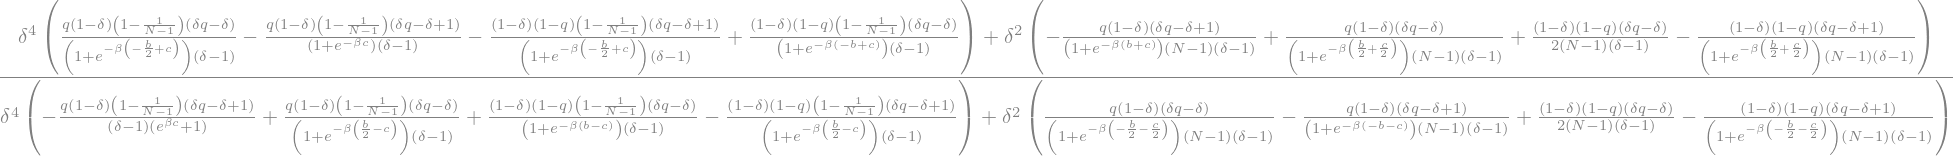

In [181]:
expr

In [182]:
numerator1 = delta ** 2 * ((N - 2) / (N - 1)) * (
    ((1 - q) * (2 * delta * q - delta + 1)) / (sym.exp(- beta*( - b / 2 + c)) + 1)  +
    q * (1 - delta + delta * q) / (sym.exp(-beta * c) + 1) +
    (delta * (1 - q) ** 2) / (sym.exp(- beta*(-b + c)) + 1))
              
numerator2 = (1 / (N - 1)) * (
    q * (1 - delta + delta * q) / (sym.exp(- beta*(b + c)) + 1) +
    (1 - q) * (2 * delta * q - delta + 1) / (sym.exp(- beta*(b/2 + c/2)) + 1) +
    (delta * (1 - q) ** 2) / 2)

In [183]:
denominator1 = delta ** 2 * ((N - 2) / (N - 1)) * (
    ((1 - q) * (2 * delta * q - delta + 1)) / (sym.exp(-beta * (b/2 - c)) + 1)  +
    q * (1 - delta + delta * q) / (sym.exp(beta*(c)) + 1) +
    (delta * (1 - q) ** 2) / (sym.exp(- beta*(b - c)) + 1))
              
denominator2 = (1 / (N - 1)) * (
    q * (1 - delta + delta * q) / (sym.exp(- beta*(-b - c)) + 1) +
    (1 - q) * (2 * delta * q - delta + 1) / (sym.exp(- beta*(-b/2 - c/2)) + 1) +
    (delta * (1 - q) ** 2) / 2)

In [184]:
result = ((sym.fraction(expr)[0] / delta ** 2) - (numerator1 + numerator2)).expand()

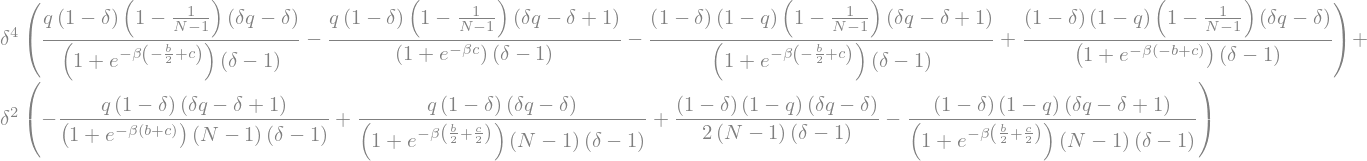

In [144]:
sym.init_printing(True)

sym.fraction(expr)[0]

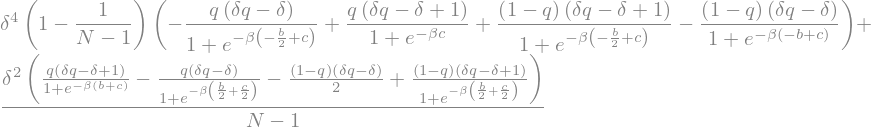

In [145]:
num = sym.fraction(expr)[0].collect(delta - 1).collect(N-1).collect(1 - (1 / (N - 1)))
num

In [185]:
(num - (numerator1 + numerator2) * delta ** 2).expand().factor()

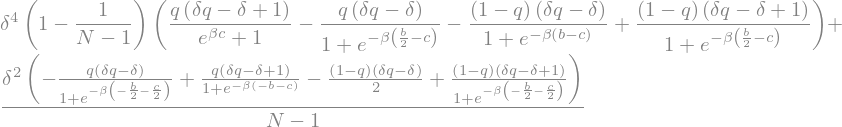

In [147]:
den = sym.fraction(expr)[1].collect(delta - 1).collect(N-1).collect(1 - (1 / (N - 1)))
den

In [186]:
(den - (denominator1 + denominator2) * delta ** 2).expand().factor()

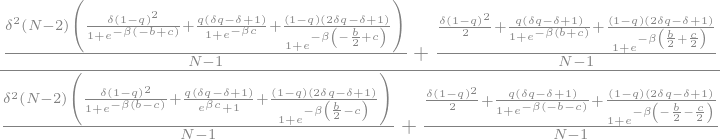

In [149]:
(numerator1 + numerator2) / (denominator1 + denominator2)

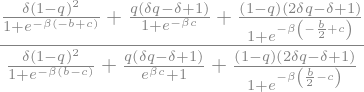

In [44]:
numerator1 / denominator1

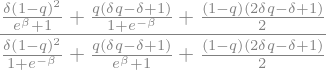

In [45]:
(numerator1 / denominator1).subs({c:1, b:2})

In [46]:
sym.limit(q * delta, beta, sym.oo)

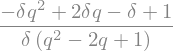

In [192]:
expr = sym.limit((numerator1 / denominator1).subs({c:2, b:3}), beta, sym.oo)

expr.simplify()

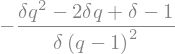

In [193]:
expr = expr.factor()
expr

In [195]:
print(sym.latex(expr))

- \frac{\delta q^{2} - 2 \delta q + \delta - 1}{\delta \left(q - 1\right)^{2}}


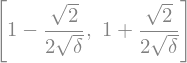

In [194]:
sym.solve(expr - 1, q)

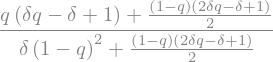

In [49]:
wrt_expr = (q * (delta * q - delta + 1) + (((1 - q) * (2 * delta * q - delta + 1)) / 2)) / (delta * (1 - q) ** 2 + (((1 - q) * (2 * delta * q - delta + 1)) / 2))
wrt_expr

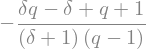

In [50]:
wrt_expr.factor()

In [51]:
(expr - wrt_expr).factor()

In [52]:
print(sym.latex(wrt_expr.factor()))

- \frac{\delta q - \delta + q + 1}{\left(\delta + 1\right) \left(q - 1\right)}


In [55]:
# wrt_expr = (delta * q - delta + 1) ** 2 / (2 * delta * (1 - q) *(delta * q - delta + 1) + delta ** 2 * (1 - q) ** 2)

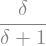

In [56]:
sym.solve((expr - 1).factor(), q)[0]

In [54]:
print(sym.latex(sym.solve((expr - 1).factor(), q)))

\left[ \frac{\delta}{\delta + 1}\right]


In [55]:
print(sym.latex(sym.solve((expr - 1).factor(), q)[0]))

\frac{\delta}{\delta + 1}


In [56]:
np.sqrt(2) / 2

### Two interactions

In [249]:
vMM = ss_last_round(alld, alld, delta)
vMR = ss_last_round(alld, gtft, delta)
vRM = ss_last_round(gtft, alld, delta)
vRR = ss_last_round(gtft, gtft, delta)

In [250]:
vMM = [v.factor() for v in vMM]
vMR = [v.factor() for v in vMR]
vRM = [v.factor() for v in vRM]
vRR = [v.factor() for v in vRR]

In [252]:
u = payoffs

Us = sym.zeros(16, 16)

for i in range(16):
    for j in range(16):
        Us[i, j] = (u[int((j) / 4)] + u[(j) % 4]) - (u[int((i) / 4)] + u[(i) % 4])

Us = Us / 2

rho = sym.zeros(16, 16);

for i in range(16):
    for j in range(16):
        rho[i, j] = 1 / (1 + sym.exp(-beta * Us[i, j]))

In [253]:
x = sym.zeros(16, 16)

k = 1

for i in range(16):
    for j in range(16):

        p_11 = int(i / 4)
        p_12 = i % 4
        q_21 = int(j / 4)
        q_22 = j % 4
        
    
        learner_role_model = 1 / (N - 1) * vRM[p_11] * int((p_11==0 and q_21==0) or (p_11==1 and q_21==2) or (p_11==2 and q_21==1) or (p_11==3 and q_21==3)) * (
            1 / (N - 2) / (N - 3) * ((k - 1) * (k - 2) * vRM[p_12] * vMM[q_22] + (k - 1) * (N - k - 1) * vRM[p_12] * vMR[q_22] + (N - k - 1) * (k - 1) * vRR[p_12] * vMM[q_22] + (N - k - 1) * (N - k - 2) * vRR[p_12] * vMR[q_22])
            )

        mutant_mutant = (1 - 1 / (N - 1)) / (N - 2) / (N - 3) * ((k-1) * (k-2) * vRM[p_11] * vMM[q_21]) * ((1 - 1 / (N - 2)) / (N - 3) / (N - 4) * ((k-2)*(k-3)*vRM[p_12]*vMM[q_22] + (k-2)*(N-k-1)*vRR[p_12]*vMM[q_22] + (N-k-1)*(k-2)*vRM[p_12]*vMR[q_22] + (N-k-1)*(N-k-2)*vRR[p_12]*vMR[q_22]) + 
        1 / (N - 2) * vRM[p_12] * int((p_12==0 and q_22==0) or (p_12==1 and q_22==2) or (p_12==2 and q_22==1) or (p_12==3 and q_22==3)))

        mutant_resident = (1 - 1 / (N - 1)) / (N - 2) / (N - 3) * ((k-1) * (N-k-1) * vRM[p_11] * vMR[q_21]) * ((1 - 1 / ( N - 2)) / (N - 3) / (N - 4) * ((k-1)*(k-3)*vRM[p_12]*vMM[q_22] + (k-1)*(N-k-1)*vRR[p_12]*vMM[q_22] + (N-k-2)*(k-2)*vRM[p_12]*vMR[q_22] + (N-k-2)*(N-k-2)*vRR[p_12]*vMR[q_22]) + 
        1 / (N - 2) * vRM[p_12] * int((p_12==0 and q_22==0) or (p_12==1 and q_22==2) or (p_12==2 and q_22==1) or (p_12==3 and q_22==3)))

        resident_mutant = (1 - 1 / (N - 1)) / (N - 2) / (N - 3) * ((N-k-1) * (k-1) * vRR[p_11] * vMM[q_21])  *  ((1 - 1 / ( N - 2)) / (N - 3) / (N - 4) * ((k-2)*(k-2)*vRM[p_12]*vMM[q_22] + (k-2)*(N-k-2)*vRR[p_12]*vMM[q_22] + (N-k-1)*(k-1)*vRM[p_12]*vMR[q_22] + (N-k-1)*(N-k-3)*vRR[p_12]*vMR[q_22]) + 
        1 / (N - 2) * vRM[p_12] * int((p_12==0 and q_22==0) or (p_12==1 and q_22==2) or (p_12==2 and q_22==1) or (p_12==3 and q_22==3)))

        resident_resident = (1 - 1 / (N - 1)) / (N - 2) / (N - 3) * (N-k-1) * (N-k-2) * vRR[p_11] * vMR[q_21] * ((1 - 1 / ( N - 2)) / (N - 3) / (N - 4) * ((k-1)*(k-2)*vRM[p_12]*vMM[q_22] + (k-1)*(N-k-2)*vRR[p_12]*vMM[q_22] + (N-k-2)*(k-1)*vRM[p_12]*vMR[q_22] + (N-k-2)*(N-k-3)*vRR[p_12]*vMR[q_22]) + 
        1 / (N - 2) * vRM[p_12] * int((p_12==0 and q_22==0) or (p_12==1 and q_22==2) or (p_12==2 and q_22==1) or (p_12==3 and q_22==3)))


        x[i, j] = (learner_role_model + (mutant_mutant + mutant_resident + resident_mutant + resident_resident)).simplify()

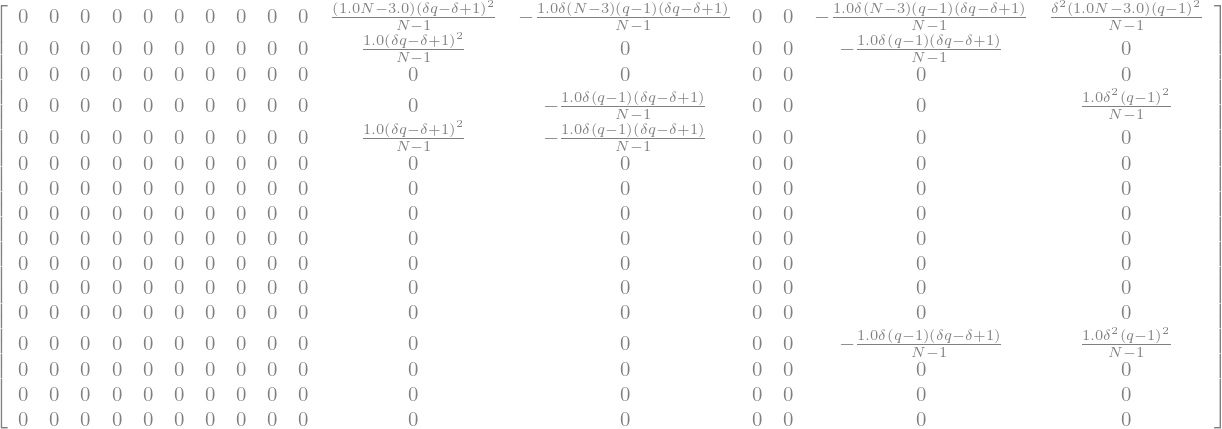

In [254]:
x

In [200]:
expr = (sum(sum(np.multiply(x, rho))) / sum(sum(np.multiply(x, rho.T))))

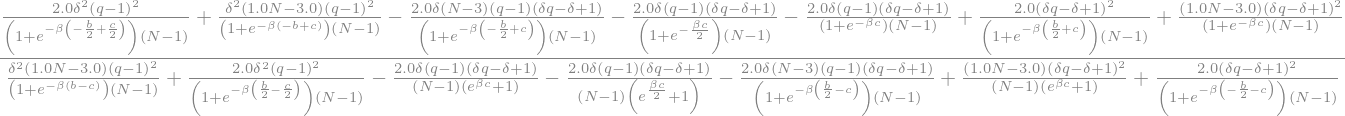

In [201]:
expr 

In [156]:
numerator1 = ((N - 3) / (N - 1)) * (
    (delta ** 2 * (1 - q) ** 2) / (sym.exp(- beta*(-b + c)) + 1) + 
    (2 * delta * (1 - q) * (delta * q - delta + 1)) / (sym.exp(- beta*(-b/2 + c)) + 1) +
    ((delta * q - delta + 1) ** 2) / (sym.exp(- beta*(c)) + 1)
)
              
numerator2 = (2 / (N - 1)) * (
    (delta ** 2 * (1 - q) ** 2) / (sym.exp(- beta*(-b/2 + c/2)) + 1) + 
    (delta * (1 - q) * (delta * q - delta + 1)) / (sym.exp(- beta*(c/2)) + 1) +
    (delta * (1 - q) * (delta * q - delta + 1)) / (sym.exp(- beta*(c)) + 1) +
    ((delta * q - delta + 1) ** 2) / (sym.exp(- beta*(b / 2 + c)) + 1))

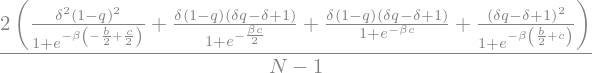

In [157]:
numerator2

In [158]:
(sym.fraction(expr)[0] - (numerator1 + numerator2)).expand().factor()

In [159]:
denominator1 = ((N - 3) / (N - 1)) * (
    (delta ** 2 * (q - 1) ** 2) / (sym.exp(- beta*(b - c)) + 1) + 
    (2 * delta * (1 - q) * (delta * q - delta + 1)) / (sym.exp(-beta*(b/2 - c)) + 1) +
    ((delta * q - delta + 1) ** 2) / (sym.exp(beta*(c)) + 1)
)
              
denominator2 = (2 / (N - 1)) * (
    (delta ** 2 * (q - 1) ** 2) / (sym.exp(- beta*(b/2 - c/2)) + 1) + 
    (delta * (1 - q) * (delta * q - delta + 1)) / (sym.exp(beta*(c/2)) + 1) +
    (delta * (1 - q) * (delta * q - delta + 1)) / (sym.exp(beta*(c)) + 1) +
    ((delta * q - delta + 1) ** 2) / (sym.exp(- beta*(-b / 2 - c)) + 1))

In [160]:
(sym.fraction(expr)[1] - (denominator1 + denominator2)).expand()

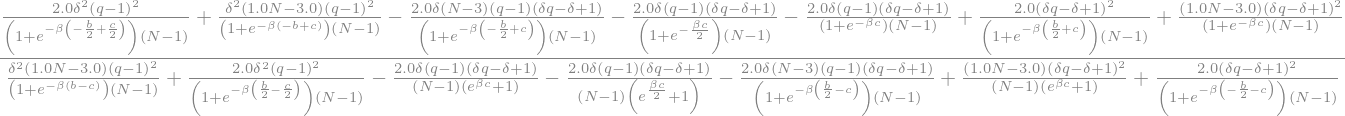

In [161]:
expr

In [162]:
up = (delta * q - delta + 1) ** 2

down = delta ** 2 * (1 - q) ** 2 + 2 * delta * (1 - q) * (delta * q - delta + 1)

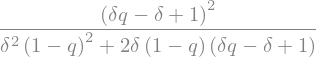

In [163]:
wrt_expre = up / down

wrt_expre

In [164]:
down.factor()

In [206]:
limit = sym.limit((numerator1 / denominator1).subs({c:2, b:3}), beta, sym.oo).factor()

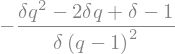

In [207]:
limit

In [208]:
print(sym.latex(limit))

- \frac{\delta q^{2} - 2 \delta q + \delta - 1}{\delta \left(q - 1\right)^{2}}


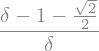

In [209]:
sym.solve(wrt_expre - 1, q)[0].simplify()

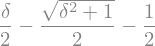

In [168]:
((delta - sym.sqrt(delta ** 2 + 1) - 1) / 2)

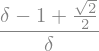

In [169]:
sym.solve(wrt_expre - 1, q)[1].simplify()

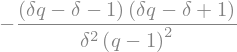

In [171]:
limit = sym.limit((numerator1 / denominator1).subs({c:2, b:3}), beta, sym.oo).factor()

limit

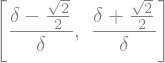

In [173]:
sym.solve(limit - 1, q)

In [69]:
v_u1 = sym.symbols("A")
v_u2 = sym.symbols("B")
v_u3 = sym.symbols("C")
v_u4 = sym.symbols("D")

vRR = [v_u1]
vRM = [v_u2]
vMR = [v_u3]
vMM =[v_u4]

i, j = 0, 0


N, k, x = sym.symbols("N, k, x")

In [87]:
A = (1 / (N - 2) / (N - 3) * ((k - 1) * (k - 2) * vRM[0] * vMM[0] + (k - 1) * (N - k - 1) * vRM[0] * vMR[0] + (N - k - 1) * (k - 1) * vRR[0] * vMM[0] + (N - k - 1) * (N - k - 2) * vRR[0] * vMR[0]))

learner_role_model = 1 / (N - 1) * vRM[0] * x 


mutant_mutant = (1 - 1 / (N - 1)) / (N - 2) / (N - 3) * ((k-1) * (k-2) * vRM[0] * vMM[0])

den = (1 - 1 / (N - 2)) / (N - 3) / (N - 4)
 
B1 = (k-2)*(k-3)*vRM[0]*vMM[0]
B2 = (k-2)*(N-k-1)*vRR[0]*vMM[0] 
B3 = (N-k-1)*(k-2)*vRM[0]*vMR[0] 
B4 = (N-k-1)*(N-k-2)*vRR[0]*vMR[0]
B5 =   1 / (N - 2) * vRM[0] * x

mutant_resident = (1 - 1 / (N - 1)) / (N - 2) / (N - 3) * ((k-1) * (N-k-1) * vRM[0] * vMR[0])

den2 = (1 - 1 / ( N - 2)) / (N - 3) / (N - 4) 

C1 = (k-1)*(k-3)*vRM[0]*vMM[0]
C2 = (k-1)*(N-k-1)*vRR[0]*vMM[0]
C3 = (N-k-2)*(k-2)*vRM[0]*vMR[0]
C4 = (N-k-2)*(N-k-2)*vRR[0]*vMR[0]
C5 = 1 / (N - 2) * vRM[0] * x

resident_mutant = (1 - 1 / (N - 1)) / (N - 2) / (N - 3) * ((N-k-1) * (k-1) * vRR[0] * vMM[0])

den3 = (1 - 1 / ( N - 2)) / (N - 3) / (N - 4)

D1 = (k-2)*(k-2)*vRM[0]*vMM[0]
D2 = (k-2)*(N-k-2)*vRR[0]*vMM[0]
D3 = (N-k-1)*(k-1)*vRM[0]*vMR[0]
D4 = (N-k-1)*(N-k-3)*vRR[0]*vMR[0]

D5 = 1 / (N - 2) * vRM[0] * x

resident_resident = (1 - 1 / (N - 1)) / (N - 2) / (N - 3) * (N-k-1) * (N-k-2) * vRR[0] * vMR[0]

den4 = (1 - 1 / ( N - 2)) / (N - 3) / (N - 4)
E1 = (k-1)*(k-2)*vRM[0]*vMM[0]
E2 = (k-1)*(N-k-2)*vRR[0]*vMM[0]
E3 = (N-k-2)*(k-1)*vRM[0]*vMR[0] 
E4 = (N-k-2)*(N-k-3)*vRR[0]*vMR[0]
E5 = 1 / (N - 2) * vRM[0] * x

# learner_role_model + (mutant_mutant + mutant_resident + resident_mutant + resident_resident)

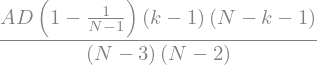

In [112]:
resident_mutant

In [109]:
print(sym.latex(resident_resident))

\frac{A C \left(1 - \frac{1}{N - 1}\right) \left(N - k - 2\right) \left(N - k - 1\right)}{\left(N - 3\right) \left(N - 2\right)}


In [105]:
print(sym.latex(E4))

A C \left(N - k - 3\right) \left(N - k - 2\right)


In [78]:
print(sym.latex(A))

\frac{A C \left(N - k - 2\right) \left(N - k - 1\right) + A D \left(k - 1\right) \left(N - k - 1\right) + B C \left(k - 1\right) \left(N - k - 1\right) + B D \left(k - 2\right) \left(k - 1\right)}{\left(N - 3\right) \left(N - 2\right)}


In [94]:
sym.init_printing(True)

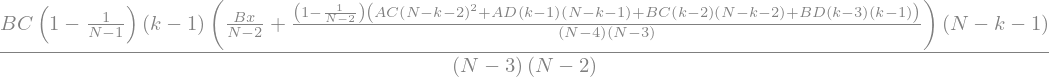

In [95]:
mutant_resident 

### Last round and two interactions

### Roots

In [129]:
vMM = ss_last_two_rounds(alld, alld, delta)
vMR = ss_last_two_rounds(alld, gtft, delta)
vRM = ss_last_two_rounds(gtft, alld, delta)
vRR = ss_last_two_rounds(gtft, gtft, delta)

In [130]:
u = payoffs
Us = sym.zeros(16, 16)


function [Rho]=calcRhoTwoFiftySix(u, beta);
    %% Calculates all possible pairwise imitation probabilities based on the last two payoffs
        new_u = log(kron(exp(u),exp(u)));
        Rho = zeros(256, 256);
    
        for i=1:256
            for j=1:256
                player = new_u(1 + fix((i - 1) / 16)) + new_u(1 + mod(i - 1, 16));
                opponent = new_u(1 + fix((j - 1) / 16)) + new_u(1 + mod(j - 1, 16));
                Rho(i, j) =  1 / (1 + exp(-beta *(opponent - player) / 2));
            end
        end
end



for i in range(16):
    for j in range(16):
        Us[i, j] = (u[int((j) / 4)] + u[(j) % 4]) - (u[int((i) / 4)] + u[(i) % 4])

Us = Us / 2

rho = sym.zeros(16, 16);

for i in range(16):
    for j in range(16):
        rho[i, j] = 1 / (1 + sym.exp(-beta * Us[i, j]))

IndentationError: unexpected indent (<ipython-input-130-e5b1a79b5ccb>, line 6)

In [131]:
x = sym.zeros(16, 16)

k = 1

for i in range(16):
    for j in range(16):

        p_11 = int(i / 4)
        p_12 = i % 4
        q_21 = int(j / 4)
        q_22 = j % 4
        
    
        learner_role_model = 1 / (N - 1) * vRM[p_11] * int((p_11==0 and q_21==0) or (p_11==1 and q_21==2) or (p_11==2 and q_21==1) or (p_11==3 and q_21==3)) * (
            1 / (N - 2) / (N - 3) * ((k - 1) * (k - 2) * vRM[p_12] * vMM[q_22] + (k - 1) * (N - k - 1) * vRM[p_12] * vMR[q_22] + (N - k - 1) * (k - 1) * vRR[p_12] * vMM[q_22] + (N - k - 1) * (N - k - 2) * vRR[p_12] * vMR[q_22])
            )

        mutant_mutant = (1 - 1 / (N - 1)) / (N - 2) / (N - 3) * ((k-1) * (k-2) * vRM[p_11] * vMM[q_21]) * ((1 - 1 / (N - 2)) / (N - 3) / (N - 4) * ((k-2)*(k-3)*vRM[p_12]*vMM[q_22] + (k-2)*(N-k-1)*vRR[p_12]*vMM[q_22] + (N-k-1)*(k-2)*vRM[p_12]*vMR[q_22] + (N-k-1)*(N-k-2)*vRR[p_12]*vMR[q_22]) + 
        1 / (N - 2) * vRM[p_12] * int((p_12==0 and q_22==0) or (p_12==1 and q_22==2) or (p_12==2 and q_22==1) or (p_12==3 and q_22==3)))

        mutant_resident = (1 - 1 / (N - 1)) / (N - 2) / (N - 3) * ((k-1) * (N-k-1) * vRM[p_11] * vMR[q_21]) * ((1 - 1 / ( N - 2)) / (N - 3) / (N - 4) * ((k-1)*(k-3)*vRM[p_12]*vMM[q_22] + (k-1)*(N-k-1)*vRR[p_12]*vMM[q_22] + (N-k-2)*(k-2)*vRM[p_12]*vMR[q_22] + (N-k-2)*(N-k-2)*vRR[p_12]*vMR[q_22]) + 
        1 / (N - 2) * vRM[p_12] * int((p_12==0 and q_22==0) or (p_12==1 and q_22==2) or (p_12==2 and q_22==1) or (p_12==3 and q_22==3)))

        resident_mutant = (1 - 1 / (N - 1)) / (N - 2) / (N - 3) * ((N-k-1) * (k-1) * vRR[p_11] * vMM[q_21])  *  ((1 - 1 / ( N - 2)) / (N - 3) / (N - 4) * ((k-2)*(k-2)*vRM[p_12]*vMM[q_22] + (k-2)*(N-k-2)*vRR[p_12]*vMM[q_22] + (N-k-1)*(k-1)*vRM[p_12]*vMR[q_22] + (N-k-1)*(N-k-3)*vRR[p_12]*vMR[q_22]) + 
        1 / (N - 2) * vRM[p_12] * int((p_12==0 and q_22==0) or (p_12==1 and q_22==2) or (p_12==2 and q_22==1) or (p_12==3 and q_22==3)))

        resident_resident = (1 - 1 / (N - 1)) / (N - 2) / (N - 3) * (N-k-1) * (N-k-2) * vRR[p_11] * vMR[q_21] * ((1 - 1 / ( N - 2)) / (N - 3) / (N - 4) * ((k-1)*(k-2)*vRM[p_12]*vMM[q_22] + (k-1)*(N-k-2)*vRR[p_12]*vMM[q_22] + (N-k-2)*(k-1)*vRM[p_12]*vMR[q_22] + (N-k-2)*(N-k-3)*vRR[p_12]*vMR[q_22]) + 
        1 / (N - 2) * vRM[p_12] * int((p_12==0 and q_22==0) or (p_12==1 and q_22==2) or (p_12==2 and q_22==1) or (p_12==3 and q_22==3)))

        x[i, j] = (learner_role_model + (mutant_mutant + mutant_resident + resident_mutant + resident_resident)).simplify()

In [132]:
p_11 = 0
p_21 = 1
q_21 = 0
q_22 = 1


1 / (N - 1) * vRM[p_11] * int((p_11==0 and q_21==0) or (p_11==1 and q_21==2) or (p_11==2 and q_21==1) or (p_11==3 and q_21==3)) 

In [209]:
1 / (N - 1) * vRM[p_11] * int((p_11==0 and q_21==0) or (p_11==1 and q_21==2) or (p_11==2 and q_21==1) or (p_11==3 and q_21==3)) * (
            1 / (N - 2) / (N - 3) * ((k - 1) * (k - 2) * vRM[p_12] * vMM[q_22] + (k - 1) * (N - k - 1) * vRM[p_12] * vMR[q_22] + (N - k - 1) * (k - 1) * vRR[p_12] * vMM[q_22] + (N - k - 1) * (N - k - 2) * vRR[p_12] * vMR[q_22])
            )

In [200]:
expr = (sum(sum(np.multiply(x, rho))) / sum(sum(np.multiply(x, rho.T))))

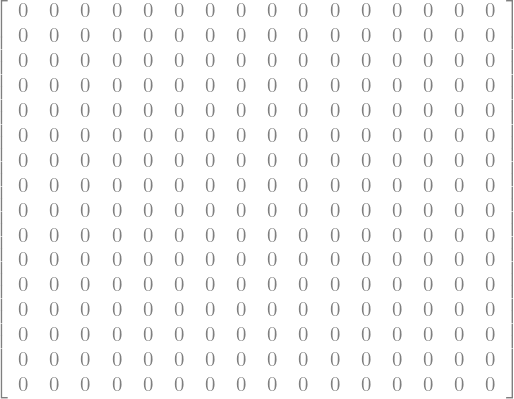

In [208]:
x

In [163]:
sym.fraction(expr)[0]

In [79]:
10000000 == 10 ** 7

True

In [96]:
np.sqrt(2) / 2

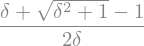

In [235]:
tworound =( delta + sym.sqrt(delta ** 2 + 1) - 1) / (2 * delta)
tworound 

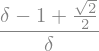

In [236]:
twoop = (delta - 1 + sym.sqrt(2) / 2) / (delta)
twoop

In [247]:
float(twoop.subs({delta:0.99}))

In [248]:
tworound.subs({delta:0.99})

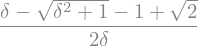

In [243]:
(twoop - tworound).factor()